In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import BertModel, BertConfig
import torch.nn as nn
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
import nltk
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [10]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/mtsamples.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
csv_file_path = path
df = pd.read_csv(csv_file_path)

In [12]:
df.columns

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')

In [13]:
len(df)

4999

In [14]:
# df = df.dropna(subset=['transcription', 'keywords'])
df = df.dropna(subset=['transcription', 'keywords'], how='any')

len(df)


3898

In [15]:
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [16]:
import string,time
string.punctuation

punctuations = string.punctuation
punctuations += "“”•™-_0123456789—*"
# {'ê', '2', '9', '8', 'ï', 'è', 'τ', '7', '•', 'â', 'α', '™', 'ε', '’', 'î', '3', 'ô', '0', '6', '4', '—', 'ὲ', 'μ', 'ὸ', 'ç', '1', 'æ', 'π', '‘', 'à', '5', 'é', '†', 'œ', 'ρ', 'δ', '–'}
# print(punctuations)
# def remove_punctuation(text):
#     for char in punctuations:
#         text = text.replace(char,'')
#     return text

# def replace_values(text):
#     text = text.replace('.,', ' ')
#     punctuation_to_replace = '-'
#     for char in punctuation_to_replace:
#         text = text.replace(char, ' ')
#     return text

def remove_punctuation(text):
    punctuations = string.punctuation
    # punctuations = punctuations.replace('.', '')
    # punctuations = punctuations.replace(',', '')
    for char in punctuations:
        text = text.replace(char, '')
    return text


def remove_tags(text):
    # if pd.isnull(text):
    #     return text
    # else:
    #     return text.strip().split('\n')
    return text.strip().split('\n')


In [17]:
# df['transcription'] = df['transcription'].apply(replace_values)
# df['keywords'] = df['keywords'].apply(replace_values)
# print(df['transcription'].iloc[0])


df['transcription'] = df['transcription'].apply(remove_punctuation)
df['keywords'] = df['keywords'].apply(remove_punctuation)
print(df['transcription'].iloc[0])

df['transcription'] = df['transcription'].apply(remove_tags)
df['keywords'] = df['keywords'].apply(remove_tags)
print(df['transcription'].iloc[0])

df['transcription'] = df['transcription'].apply(lambda x: x[0].lower())
df['keywords'] = df['keywords'].apply(lambda x: x[0].lower())
print(df['transcription'].iloc[0])


SUBJECTIVE  This 23yearold white female presents with complaint of allergies  She used to have allergies when she lived in Seattle but she thinks they are worse here  In the past she has tried Claritin and Zyrtec  Both worked for short time but then seemed to lose effectiveness  She has used Allegra also  She used that last summer and she began using it again two weeks ago  It does not appear to be working very well  She has used overthecounter sprays but no prescription nasal sprays  She does have asthma but doest not require daily medication for this and does not think it is flaring upMEDICATIONS  Her only medication currently is Ortho TriCyclen and the AllegraALLERGIES  She has no known medicine allergiesOBJECTIVEVitals  Weight was 130 pounds and blood pressure 12478HEENT  Her throat was mildly erythematous without exudate  Nasal mucosa was erythematous and swollen  Only clear drainage was seen  TMs were clearNeck  Supple without adenopathyLungs  ClearASSESSMENT  Allergic rhinitisPL

In [18]:
df['transcription'].iloc[0]

'subjective  this 23yearold white female presents with complaint of allergies  she used to have allergies when she lived in seattle but she thinks they are worse here  in the past she has tried claritin and zyrtec  both worked for short time but then seemed to lose effectiveness  she has used allegra also  she used that last summer and she began using it again two weeks ago  it does not appear to be working very well  she has used overthecounter sprays but no prescription nasal sprays  she does have asthma but doest not require daily medication for this and does not think it is flaring upmedications  her only medication currently is ortho tricyclen and the allegraallergies  she has no known medicine allergiesobjectivevitals  weight was 130 pounds and blood pressure 12478heent  her throat was mildly erythematous without exudate  nasal mucosa was erythematous and swollen  only clear drainage was seen  tms were clearneck  supple without adenopathylungs  clearassessment  allergic rhinitisp

In [19]:
len(df)

3898

Max Length :  2003
Min Length :  1


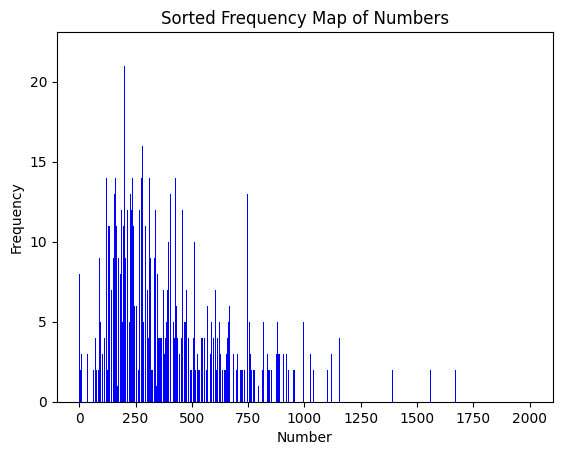

In [20]:
word_lengths = []

for sent in df['transcription']:
    word_lengths.append(len(sent.split()))

print("Max Length : ", max(word_lengths))
print("Min Length : ", min(word_lengths))

from collections import Counter
frequency_map = Counter(word_lengths)

# Sort the values and frequencies in ascending order
sorted_values, sorted_frequencies = zip(*sorted(frequency_map.items()))

# Plotting the sorted frequency map
plt.bar(sorted_values, sorted_frequencies, color='blue')

# Adding labels and title
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Sorted Frequency Map of Numbers')

# Display the plot
plt.show()

Max Length :  118
Min Length :  0


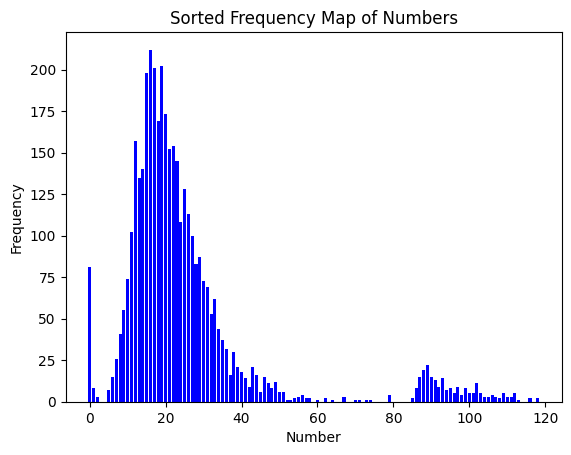

In [21]:
word_lengths = []

for sent in df['keywords']:
    word_lengths.append(len(sent.split()))

print("Max Length : ", max(word_lengths))
print("Min Length : ", min(word_lengths))

from collections import Counter
frequency_map = Counter(word_lengths)

# Sort the values and frequencies in ascending order
sorted_values, sorted_frequencies = zip(*sorted(frequency_map.items()))

# Plotting the sorted frequency map
plt.bar(sorted_values, sorted_frequencies, color='blue')

# Adding labels and title
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Sorted Frequency Map of Numbers')

# Display the plot
plt.show()

In [22]:
from transformers import BertTokenizer, BertModel
import torch

# Define the maximum sequence length
max_length = 500

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [52]:
class MedicalKeywordDataset(Dataset):
    def __init__(self, df, tokenizer, max_length, final_length):
        self.df = df
        self.transcript = df['transcription']
        self.keywords = df['keywords']
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.final_length = final_length

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        transcript_tokens = self.tokenizer(
            self.transcript.iloc[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        keyword_tokens = self.tokenizer(
            self.keywords.iloc[idx],
            padding='max_length',
            truncation=True,
            max_length=self.final_length,
            return_tensors='pt'
        )

        transcript_tokens = transcript_tokens.to(device)
        keyword_tokens = keyword_tokens.to(device)

        return {'transcript_tokens': transcript_tokens, 'keyword_tokens': keyword_tokens}

# Usage
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train, test = train_test_split(df, train_size=0.9, random_state=34)

ds_train = MedicalKeywordDataset(train, tokenizer, 1000, 110)
ds_test = MedicalKeywordDataset(test, tokenizer, 1000, 110)

batch_size = 4
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)


In [65]:
# for val in train_dataloader:
#     print( val['transcript_tokens'])
#     print( val['keyword_tokens'])
#     # print( val[1])

#     # print(val[0])

#     break

In [28]:
tokenizer = BertTokenizer.from_pretrained('nlpaueb/bert-base-uncased-echr')
maxi_length = 1500
# # Tokenize, truncate and pad sequences to a maximum length
# train_encodings = tokenizer(list(df_train["text_combined"]), padding = True, return_tensors = 'pt', max_length = maxi_length, truncation = True)
# validation_encodings = tokenizer(list(df_validation["text_combined"]), padding = True, return_tensors = 'pt', max_length = maxi_length, truncation = True)
# test_encodings = tokenizer(list(df_test["text_combined"]), padding = True, return_tensors = 'pt', max_length = maxi_length, truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

In [81]:
# class BertForPrediction(nn.Module):
#     def __init__(self):
#         super(BertForPrediction, self).__init__()
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         self.dropout = nn.Dropout(0.1)

# #     def forward(self, input_ids, attention_mask):
# #         window_size = 512
# #         num_windows = (input_ids.size(1) - 1) // window_size + 1
# #         window_hidden_states = []

# #         for i in range(num_windows):
# #             start_idx = i * window_size
# #             end_idx = min((i + 1) * window_size, input_ids.size(1))
# #             window_input_ids = input_ids[:, start_idx: end_idx]
# #             window_attention_mask = attention_mask[:, start_idx: end_idx]

# #             # Unpack the dictionary
# #             outputs = self.bert(input_ids=window_input_ids, attention_mask=window_attention_mask)
# #             window_hidden_states.append(outputs.last_hidden_state[:, 0, :])

# #         embeddings = torch.stack(window_hidden_states, dim=0).mean(dim=0)
# #         # embeddings = self.out(embeddings)
# #         return embeddings


#     def forward(self, input_ids, attention_mask):
#         window_size = 512
#         num_windows = (input_ids.size(1) - 1) // window_size + 1  # Calculate the number of windows
#         window_hidden_states = []

#         for i in range(num_windows):
#             start_idx = i * window_size
#             end_idx = min((i + 1) * window_size, input_ids.size(1))
#             window_input_ids = input_ids[:, start_idx: end_idx]
#             window_attention_mask = attention_mask[:, start_idx: end_idx]

#             outputs = self.bert(input_ids=window_input_ids, attention_mask=window_attention_mask)
#             print(outputs)
#             window_hidden_states.append(outputs.last_hidden_state[:, 0, :])

#         avg_hidden_states = torch.stack(window_hidden_states, dim = 0).mean(dim = 0)
#         logits = self.out(avg_hidden_states)
#         return logits



class BertForPrediction(nn.Module):
    def __init__(self):
        super(BertForPrediction, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        window_size = 512
        num_windows = (input_ids.size(1) - 1) // window_size + 1  # Calculate the number of windows
        window_hidden_states = []

        for i in range(num_windows):
            start_idx = i * window_size
            end_idx = min((i + 1) * window_size, input_ids.size(1))
            window_input_ids = input_ids[:, start_idx: end_idx]
            window_attention_mask = attention_mask[:, start_idx: end_idx]

            outputs = self.bert(input_ids=window_input_ids, attention_mask=window_attention_mask)
            print(outputs)
            window_hidden_states.append(outputs.last_hidden_state[:, 0, :])

        avg_hidden_states = torch.stack(window_hidden_states, dim=0).mean(dim=0)
        logits = self.out(avg_hidden_states)
        return logits


In [82]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from tqdm import tqdm

# Assuming you have a DataLoader named train_dataloader and your model
# has already been defined and initialized (e.g., model = BertForPrediction())

# Hyperparameters
learning_rate = 1e-5
num_epochs = 5

# Initialize the model, optimizer, and loss function
model = BertForPrediction()  # Change your_output_dimension accordingly
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Dummy DataLoader (replace this with your actual DataLoader)
# train_dataloader = train_df
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

BertForPrediction(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [146]:


for epoch in range(num_epochs):
    total_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # print(batch)
        # batch = batch[0]
        # print(batch[0]['input_ids'])
        inputs = batch['transcript_tokens']['input_ids'].to(device)
        attention_mask = batch['transcript_tokens']['attention_mask'].to(device)

        targets = batch['keyword_tokens']['input_ids'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs, attention_mask)
        print(outputs.shape, outputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}')

# Save the trained model if needed
torch.save(model.state_dict(), 'bert_prediction_model.pth')


In [ ]:
text = "This is an example sentence. You can replace it with your own text."

# Tokenize the text
tokens = tokenizer(text, max_length=max_length, truncation=True, padding=True, return_tensors='pt')

# Forward pass through the model
outputs = model(**tokens)

# Get the output embeddings from the model
last_hidden_states = outputs.last_hidden_state

# # Print the shape of the output embeddings
# print("Shape of the output embeddings:", last_hidden_states.shape)

# Extract the [CLS] token representation (located at the first position)
cls_token = last_hidden_states[:, 0, :]

# Print the shape of the [CLS] token representation
print("Shape of the [CLS] token representation:", cls_token.shape)

In [ ]:
max_chunk_size = 5
text = "This is an example sentence. You can replace it with your own text."

tokenized_sentence = tokenizer.tokenize(text)
word_count = len(tokenized_sentence)

# Split the sentence into chunks based on the number of words
chunks = [tokenized_sentence[i:i+max_chunk_size] for i in range(0, word_count, max_chunk_size)]

# Join the token chunks to form sub-sentences
sub_sentences = [' '.join(chunk) for chunk in chunks]

print(sub_sentences)
# Process each chunk

cls_token_chunk_list = []
average = torch.zeros(1, 768)

for chunk in sub_sentences:
    tokenized_chunk = tokenizer(chunk, max_length=max_chunk_size, truncation=True, return_tensors='pt')

    # Forward pass through the model for the chunk
    outputs_chunk = model(**tokenized_chunk)

    # Get the [CLS] token representation for the chunk
    cls_token_chunk = outputs_chunk.last_hidden_state[:, 0, :]

    cls_token_chunk_list.append(cls_token_chunk)
    average += cls_token_chunk
    # Print the shape of the [CLS] token representation for the chunk
    print("Shape of the [CLS] token representation for the chunk:", cls_token_chunk.shape)

average /= len(sub_sentences)

concatenated_cls_tokens = torch.stack(cls_token_chunk_list, dim=0)

print("concatenated_cls_tokens : ", concatenated_cls_tokens.shape)
print("average : ", average.shape)

In [ ]:
# import torch
# import torch.nn as nn

# # Assuming cls_token_chunk_list is a tensor representing [CLS] token embeddings for each chunk

# # Define an LSTM layer
# lstm_input_size = 768  # Assuming BERT provides 768-dimensional embeddings
# hidden_size = 768  # Adjusted to match the desired output size
# num_layers = 2  # Adjust as needed
# bidirectional = True  # Adjust as needed
# dropout = 0.1  # Adjust as needed

# lstm_layer = nn.LSTM(input_size=lstm_input_size,
#                      hidden_size=hidden_size,
#                      num_layers=num_layers,
#                      bidirectional=bidirectional,
#                      dropout=dropout,
#                      batch_first=True)

# # Forward pass through the LSTM layer
# output, (final_hidden_state, final_cell_state) = lstm_layer(concatenated_cls_tokens)

# # Extract the hidden state at the last time step from the last layer
# overall_representation = final_hidden_state[-1, :, :]

# # Reshape to [1, 768]
# overall_representation = overall_representation.unsqueeze(0)

# # The overall_representation contains the representation for the entire long sentence
# print("Shape of the overall representation:", overall_representation.shape)


In [ ]:
# concatenated_cls_tokens.squeeze(1).shape

# for tokens in concatenated_cls_tokens:

In [ ]:

class BertForSequenceClassification(nn.Module):
    def __init__(self):
        super(BertForSequenceClassification, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids):
        tokenized_sentence = tokenizer.tokenize(text)
        word_count = len(tokenized_sentence)

        # Split the sentence into chunks based on the number of words
        chunks = [tokenized_sentence[i:i+max_chunk_size] for i in range(0, word_count, max_chunk_size)]

        # Join the token chunks to form sub-sentences
        sub_sentences = [' '.join(chunk) for chunk in chunks]

        print(sub_sentences)
        # Process each chunk

        # cls_token_chunk_list = []
        average = torch.zeros(1, 768)

        for chunk in sub_sentences:
            tokenized_chunk = tokenizer(chunk, max_length=max_chunk_size, truncation=True, return_tensors='pt')
            outputs_chunk = model(**tokenized_chunk)
            cls_token_chunk = outputs_chunk.last_hidden_state[:, 0, :]
            # cls_token_chunk_list.append(cls_token_chunk)
            average += cls_token_chunk
            # Print the shape of the [CLS] token representation for the chunk
            # print("Shape of the [CLS] token representation for the chunk:", cls_token_chunk.shape)

        average /= len(sub_sentences)
        return average

In [ ]:
# Training loop
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_df:
        input_ids_batch, labels_batch = batch
        input_ids_batch, labels_batch = input_ids_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids_batch, labels=labels_batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_df)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}')


Simple Token embedding matching using bert

In [85]:

import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [86]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')  # Download the stop words dataset

# Assuming 'word' is the word you want to check
word = 'your_word_here'

stop_words = set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [138]:
def predict_labels(sentence, limit=0.6):
    # Example sentence and reference word
    # sentence = "informed consent was obtained, the patient was brought to the operative suite and placed supine on the operating table.  General endotracheal anesthesia was induced without incident.  The patient was prepped and draped in the usual sterile manner.,A standard inguinal incision was made and dissection was carried down to the external oblique aponeurosis using a combination of Metzenbaum scissors and Bovie electrocautery.  The external oblique aponeurosis was cleared of overlying adherent tissue, and the external ring was delineated.  The external oblique was then incised with a scalpel, and this incision was carried out to the external ring using Metzenbaum scissors.  Having exposed the inguinal canal, the cord structures were separated from the canal using blunt dissection, and a Penrose drain was placed around the cord structures at the level of the pubic tubercle.  This Penrose drain was then used to retract the cord structures as needed.  Adherent cremasteric muscle was dissected free from the cord using Bovie electrocautery.,The cord was then explored using a combination of sharp and blunt dissection, and the sac was found anteromedially to the cord structures.  The sac was dissected free from the cord structures using a combination of blunt dissection and Bovie electrocautery.  Once preperitoneal fat was encountered, the dissection stopped and the sac was suture ligated at the level of the preperitoneal fat using a 2-0 silk suture ligature.  The sac was excised and went to  Pathology.  The ends of the suture were then cut and the stump retracted back into the abdomen.,The Penrose drain was removed.  The wound was then irrigated using sterile saline, and hemostasis was obtained using Bovie electrocautery.  The incision in the external oblique was approximated using a 3-0 Vicryl in a running fashion, thus reforming the external ring.  The skin incision was approximated with 4-0 Vicryl in a subcuticular fashion.  The skin was prepped and draped with benzoin, and Steri-Strips were applied.  A dressing consisting of a 2 x 2 and OpSite was then applied.  All surgical counts were reported as correct.,Having tolerated the procedure well, the patient was subsequently extubated and taken to the recovery room in good and stable condition."
    # reference_word = "example"
    # sentence = "REASON FOR VISIT: , Follow up consultation, second opinion, foreskin.,HISTORY OF PRESENT ILLNESS: , A 2-week-old who at this point has otherwise been doing well.  He has a relatively unremarkable foreskin.  At this point in time, he otherwise seems to be doing reasonably well.  The question is about the foreskin.  He otherwise has no other significant issues.  Severity low, ongoing since birth two weeks.  Thank you for allowing me to see this patient in consultation.,PHYSICAL EXAMINATION:,  Male exam.  Normal and under the penis, report normal uncircumcised 2-week-old.  He has a slightly insertion on the penile shaft from the median raphe of the scrotum.,IMPRESSION: , Slightly high insertion of the median raphe.  I see no reason he cannot be circumcised as long as they are careful and do a very complete Gomco circumcision.  This kid should otherwise do reasonably well.,PLAN:  ,Follow up as needed.  But my other recommendation is that this kid as I went over with the mother may actually do somewhat better if he simply has a formal circumcision at one year of age, but may do well with a person who is very accomplished doing a Gomco circumcision."
    # Tokenize the sentence and reference word


    sentence = sentence.lower()
    sentence = remove_punctuation(sentence)
    sentence = remove_tags(sentence)

    print(sentence)
    sentence = " ".join(sentence)

    tokenized_sentence = tokenizer(sentence, return_tensors='pt')

    # Forward pass through the BERT model to get embeddings
    with torch.no_grad():
        sentence_embeddings = model(**tokenized_sentence).last_hidden_state[:, 0, :]

    total_embeddings = []
    words = []
    with torch.no_grad():
        for reference_word in sentence.split():
            # print(reference_word)
            words.append(reference_word)
            tokenized_reference = tokenizer(reference_word, return_tensors='pt')
            reference_embedding = model(**tokenized_reference).last_hidden_state[:, 0, :]
            total_embeddings.append(reference_embedding)


    # Calculate cosine similarity
    # Define a threshold
    predicted_words = []
    cosine_similarity_lst = []
    threshold = 0.5
    for ref in range(len(total_embeddings)):
        # print(ref)
        # print(sentence_embeddings.shape,sentence_embeddings.shape )
        # print(reference_embedding.shape,reference_embedding.shape )
        cosine_similarity_lst.append(cosine_similarity(sentence_embeddings, total_embeddings[ref])[0, 0])
        # print("cosine : ", words[ref], " ", cosine_similarity_value)


    predicted_words = set()
    for ref in range(len(cosine_similarity_lst)):
        if(cosine_similarity_lst[ref] > limit and words[ref] not in stop_words):
            predicted_words.add(words[ref])

    print("Predicted words:", predicted_words)
    return " ".join(predicted_words)

In [141]:
index = 10
ans = predict_labels(df.iloc[index]['transcription'])

['preoperative diagnosis  morbid obesity postoperative diagnosis  morbid obesity procedure  laparoscopic rouxeny gastric bypass antecolic antegastric with 25mm eea anastamosis esophagogastroduodenoscopy anesthesia  general with endotracheal intubation indications for procedure  this is a 50yearold male who has been overweight for many years and has tried multiple different weight loss diets and programs  the patient has now begun to have comorbidities related to the obesity  the patient has attended our bariatric seminar and met with our dietician and psychologist  the patient has read through our comprehensive handout and understands the risks and benefits of bypass surgery as evidenced by the signing of our consent formprocedure in detail  the risks and benefits were explained to the patient  consent was obtained  the patient was taken to the operating room and placed supine on the operating room table  general anesthesia was administered with endotracheal intubation  a foley cathete

In [ ]:
rouge_scores = calculate_rouge(df.iloc[index]['keywords'], ans)
print("ROUGE Scores:", rouge_scores)

KEYBERT

In [96]:
!pip install keybert -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.5 MB/s eta 0:00:00


In [97]:
from keybert import KeyBERT
kw_model = KeyBERT()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [123]:

def predict_keyBert(transcript, top_n=15):
    print(kw_model.extract_keywords(transcript, keyphrase_ngram_range=(1, 2), stop_words='english',
                                  use_maxsum=True, nr_candidates=20, top_n=top_n))
    print(kw_model.extract_keywords(transcript, keyphrase_ngram_range=(1, 2), stop_words='english',
                                  use_mmr=True, diversity=0.7))
    print(kw_model.extract_keywords(transcript, keyphrase_ngram_range=(1, 2), stop_words='english',
                              use_mmr=True, diversity=0.1))
    tpl = kw_model.extract_keywords(transcript, keyphrase_ngram_range=(1, 2), stop_words='english',
                              use_mmr=True, diversity=0.1)
    ans = []
    for val in tpl:
        ans.append(val[0])

    return " ".join(ans)

In [125]:
index = 100
ans = predict_keyBert(df.iloc[index]['transcription'])

[('meatus urethral', 0.3926), ('catheterestimated', 0.3943), ('verified anesthetized', 0.4027), ('catheterestimated blood', 0.403), ('operation patient', 0.4039), ('coronal cuff', 0.4098), ('catheter placed', 0.4191), ('hypospadias', 0.4227), ('urethroplasty plate', 0.4279), ('chordeeprocedure', 0.4348), ('diagnosis coronal', 0.4529), ('chordeepostoperative', 0.4795), ('hypospadias chordee', 0.5131), ('chordeepostoperative diagnosis', 0.5298), ('hypospadias repair', 0.5411)]
[('hypospadias chordeepostoperative', 0.6543), ('marked coronal', 0.3357), ('iv antibiotics', 0.2639), ('approximate penile', 0.1483), ('condition transfer', 0.0991)]
[('hypospadias chordeepostoperative', 0.6543), ('coronal hypospadias', 0.6205), ('hypospadias chordeeprocedure', 0.6087), ('chordeeprocedure hypospadias', 0.6053), ('hypospadias repair', 0.5411)]


In [126]:
print("Predicted : ", ans)
print("Ground truth : ", df.iloc[index]['keywords'])

Predicted :  hypospadias chordeepostoperative coronal hypospadias hypospadias chordeeprocedure chordeeprocedure hypospadias hypospadias repair
Ground truth :  urology tissue flap relocation urethroplasty plate incision penile shaft skin chordee release zaontz catheter penile shaft hypospadias repair flap relocation coronal cuff urethral plate tissue flap hypospadias flap chordee


In [127]:


def calculate_rouge(reference, candidate):
    # Tokenize the sentences
    reference = nltk.word_tokenize(reference.lower())
    candidate = nltk.word_tokenize(candidate.lower())

    # Calculate ROUGE scores
    smoothing_function = SmoothingFunction().method1
    rouge_scores = corpus_bleu([reference], [candidate], smoothing_function=smoothing_function)

    return rouge_scores

In [128]:
rouge_scores = calculate_rouge(df.iloc[index]['keywords'], ans[0])
print("ROUGE Scores:", rouge_scores)

ROUGE Scores: 0.008853531856477262
